In [1]:
from astropy.table import Table, vstack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import astropy.units as u

In [4]:
decals_raw = Table.read('GalfitM_DECALS_183.csv', format='ascii')
decals = decals_raw[decals_raw['type_1'] != 'PSF']
d_stars = decals_raw[decals_raw['type_1'] == 'PSF']
#splus = Table.read('/home/seba/Documents/CG/MorphoPLUS_SFCGs/Morphoplus_groups/Catalogos_try/GalfitM_output_final_3.csv', format='ascii')
# Definir las columnas que deseas cambiar
'''columnas_a_cambiar = ['n_R', 'n_G', 'n_I', 'n_Z', 'RE_R', 'RE_G', 'RE_I', 'RE_Z', 'MAG_R', 'MAG_G', 'MAG_I', 'MAG_Z']

# Crear un diccionario para mapear los nombres antiguos a los nuevos solo para las columnas específicas
column_mapping = {col: re.sub(r'_(G|R|I|Z)', lambda x: f'_{x.group(1).lower()}', col) for col in columnas_a_cambiar}

# Renombrar las columnas en la tabla
for old_name, new_name in column_mapping.items():
    if old_name in splus.colnames:
        splus.rename_column(old_name, new_name)'''
decals

Group_1,Gal_1,ID,ra_1,dec_1,type_1,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g_1,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r_1,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i_1,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z_1,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,type_2,ra_2,dec_2,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g_2,mag_r_2,mag_i_2,mag_z_2,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,_RAJ2000,_DEJ2000,Group_2,Gal_2,RAJ2000,DEJ2000,zmemb,gmemb,FUV,NUV,Simbad,Separation_2,Separation
int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,str10,str12,float64,float64,str9,str11,str8,str13,float64,float64,float64,float64,float64,float64,str10,str12,float64,float64,str9,str11,str8,str13,float64,float64,float64,float64,float64,float64,str8,str12,float64,float64,str9,str11,str8,str13,float64,float64,float64,float64,float64,float64,str9,str12,str9,str9,str9,str11,str8,str13,float64,float64,int64,str8,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str11,str11,float64,int64,float64,float64,str6,float64,float64
1,1,1645,0.079356474601419,-22.57609230832414,SER,0.444957228535091,892.2833,0.0039,838.5585,0.0041,9.8294,0.0435,18.256,0.0034,1.7689,0.0117,0.9451,0.0017,24.0265,1.1276,892.2833,0.0039,838.5585,0.0041,9.0826,0.0228,17.6082,0.0018,2.3542,0.0070,0.9451,0.0017,24.0265,1.1276,892.2833,0.0039,838.5585,0.0041,8.3702,0.0367,17.3253,0.0028,2.9126,0.0137,0.9451,0.0017,24.0265,1.1276,892.2833,0.0039,838.5585,0.0041,7.5989,0.0678,17.2215,0.0056,3.5171,0.0241,0.9451,0.0017,24.0265,1.1276,203988,0001m225,1645,SER,0.079356474601419,-22.57609230832414,0.017528892,48.266956,92.56008,126.76573,154.32976,1.4651365,1.2320019,1.3169467,1.1513813,2.8488412,13063.839,2.6694756,61024.297,0.017965661,632260.8,0.022896547,737468.5,18.290874,17.58394,17.242495,17.028875,17.22928,17.531992,15.749675,--,0.706934,0.34144592,0.55506516,0.21361923,0.0790833,-22.5758889,1,1,00 00 18.98,-22 34 33.2,0.0,--,20.2714,19.9779,Simbad,1.166537474480667,0.0
1,3,2068,0.1003956575335607,-22.58890589524607,SER,0.444957228535091,625.556,0.0053,662.3559,0.007,13.0738,0.0145,17.5166,0.0011,0.5929,0.0020,0.7279,0.0005,-1.3852,0.0969,625.556,0.0053,662.3559,0.007,12.7210,0.0083,16.9496,0.0007,0.7123,0.0010,0.7279,0.0005,-1.3852,0.0969,625.556,0.0053,662.3559,0.007,12.3844,0.0121,16.6317,0.0009,0.8263,0.0017,0.7279,0.0005,-1.3852,0.0969,625.556,0.0053,662.3559,0.007,12.0200,0.0215,16.4840,0.0019,0.9497,0.0032,0.7279,0.0005,-1.3852,0.0969,203988,0001m225,2068,SER,0.1003956575335607,-22.58890589524607,0.017668108,96.314026,164.30281,224.06183,262.9318,1.374724,1.2320019,1.4043026,1.1513813,0.74041283,241120.66,3.2906244,205470.22,0.15574026,3809064.5,-0.010747138,1612471.6,17.540775,16.960888,16.62408,16.450392,16.640575,17.031475,15.055349,12.263554,0.5798874,0.33680725,0.51049614,0.17368889,0.1002083,-22.5888056,1,3,00 00 24.05,-22 35 19.7,0.0,--,19.3392,19.222,Simbad,0.7198446044828247,0.0
1,2,1873,0.0912554639415616,-22.58790183800087,SER,0.444957228535091,741.4711,0.0127,676.2068,0.0073,8.3541,0.0228,18.9807,0.0025,0.4985,0.0061,0.4999,0.0010,76.0773,0.1251,741.4711,0.0127,676.2068,0.0073,8.3075,0.0169,18.6522,0.0021,0.6517,0.0035,0.4999,0.0010,76.0773,0.1251,741.4711,0.0127,676.2068,0.0073,8.2629,0.0276,18.4092,0.0031,0.7978,0.0070,0.4999,0.0010,76.0773,0.1251,741.4711,0.0127,676.2068,0.0073,8.2147,0.0452,18.3382,0.0064,0.9559,0.0125,0.4999,0.0010,76.0773,0.1251,203988,0001m225,1873,SER,0.0912554639415616,-22.58790183800087,0.017578758,25.540777,3

In [5]:
filtros = ['g', 'r', 'i', 'z']
#filtros_splus = ['G', 'R', 'I', 'Z']
for filtro in filtros:        
    decals['n_' + filtro] = pd.to_numeric(decals['n_' + filtro], errors='coerce')
    decals['RE_' +filtro] = pd.to_numeric(decals['RE_' + filtro], errors = 'coerce')
    decals['e_n_' + filtro] = pd.to_numeric(decals['n_' + filtro], errors='coerce')
    decals['e_RE_' +filtro] = pd.to_numeric(decals['RE_' + filtro], errors = 'coerce')
    d_stars['n_' + filtro] = pd.to_numeric(d_stars['n_' + filtro], errors='coerce')
    d_stars['RE_' +filtro] = pd.to_numeric(d_stars['RE_' + filtro], errors = 'coerce')
    d_stars['e_n_' + filtro] = pd.to_numeric(d_stars['n_' + filtro], errors='coerce')
    d_stars['e_RE_' +filtro] = pd.to_numeric(d_stars['RE_' + filtro], errors = 'coerce')
#    splus['n_' + filtro] = pd.to_numeric(splus['n_' + filtro], errors='coerce')
#    splus['RE_' +filtro] = pd.to_numeric(splus['RE_' + filtro], errors = 'coerce')
#    splus['MAG_' +filtro] = pd.to_numeric(splus['MAG_' + filtro], errors = 'coerce')
#    splus['e_n_' + filtro] = pd.to_numeric(splus['n_' + filtro], errors='coerce')
#    splus['e_RE_' +filtro] = pd.to_numeric(splus['RE_' + filtro], errors = 'coerce')

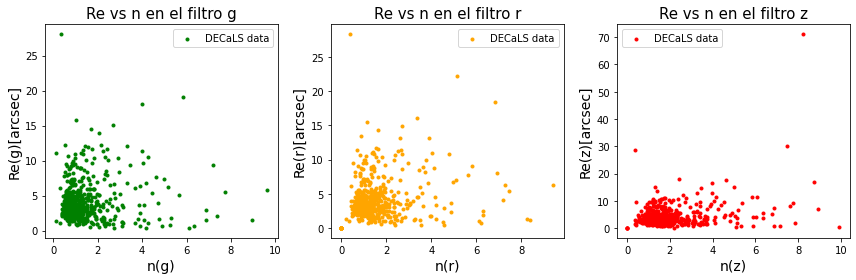

NameError: name 'splus' is not defined

In [6]:
# Función para graficar Re vs n en grz.
def graficar_re_n(axs, archivo, color_g, color_r, color_z, label, pixel_scale):
    
    # Convertir las columnas de interés a tipos de datos numéricos
    for filtro in filtros:
        archivo['n_' + filtro] = pd.to_numeric(archivo['n_' + filtro], errors='coerce')
        archivo['RE_' +filtro] = pd.to_numeric(archivo['RE_' + filtro], errors = 'coerce')
    
    axs[0].scatter(archivo['n_g'], archivo['RE_g']*pixel_scale, label=label, color=color_g, marker='.')
    axs[0].set_xlabel('n(g)', fontsize = 14)
    axs[0].set_ylabel('Re(g)[arcsec]', fontsize=14)
    axs[0].set_title(f'Re vs n en el filtro g', fontsize=15)
    axs[0].set_xlim()
    axs[0].set_ylim()

    axs[1].scatter(archivo['n_r'], archivo['RE_r']*pixel_scale, label=label, color=color_r, marker='.')
    axs[1].set_xlabel('n(r)', fontsize = 14)
    axs[1].set_ylabel('Re(r)[arcsec]', fontsize=14)
    axs[1].set_title(f'Re vs n en el filtro r', fontsize=15)
    axs[1].set_xlim()
    axs[1].set_ylim()

    axs[2].scatter(archivo['n_z'], archivo['RE_z']*pixel_scale, label=label, color=color_z, marker='.')
    axs[2].set_xlabel('n(z)', fontsize = 14)
    axs[2].set_ylabel('Re(z)[arcsec]', fontsize=14)
    axs[2].set_title(f'Re vs n en el filtro z', fontsize=15)
    axs[2].set_xlim()
    axs[2].set_ylim()
    
    # Añadir leyenda en cada sub-gráfico
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Graficar
graficar_re_n(axs[:], decals[decals['n_i']!=0.0], 'green', 'orange', 'red', 'DECaLS data', 0.262)
#graficar_re_n(axs[:], splus, 'cyan', 'darkorchid', 'pink', 'SPLUS data', 0.55)
#graficar_re_n(axs[:], d_stars[d_stars['n_i'] !=0.0], 'blue', 'black', 'lightgreen', 'Stars', 0.262)
# Ajustar diseño y mostrar gráficos
plt.legend()
plt.tight_layout()
plt.show()
print(len(decals[decals['n_i']!=0.0]), len(splus))


In [20]:
valores_sersic = np.array([decals['n_' + filtro] for filtro in filtros])
valores_sersic_splus = np.array([splus['n_'+filtro] for filtro in filtros])
# Función para calcular la mediana sin NaN y ceros
def calcular_mediana_sin_nan_ni_ceros(valores):
    # Filtrar NaN y ceros
    valores_filtrados = valores[(~np.isnan(valores)) & (valores != 0)]
    if len(valores_filtrados) > 0:
        return np.median(valores_filtrados)
    else:
        return np.nan

# Calcular medianas para cada filtro en 'valores_sersic'
medianas_valores_sersic = np.array([calcular_mediana_sin_nan_ni_ceros(valores_sersic[i]) for i in range(len(filtros))])

# Calcular medianas para cada filtro en 'valores_sersic_splus'
medianas_valores_sersic_splus = np.array([calcular_mediana_sin_nan_ni_ceros(valores_sersic_splus[i]) for i in range(len(filtros))])

# Imprimir resultados
print("Medianas para valores_sersic:")
print(medianas_valores_sersic)

print("\nMedianas para valores_sersic_splus:")
print(medianas_valores_sersic_splus)

Medianas para valores_sersic:
[1.1034  1.2702  1.4277  1.51955]

Medianas para valores_sersic_splus:
[1.0666  1.24275 1.39305 1.4659 ]


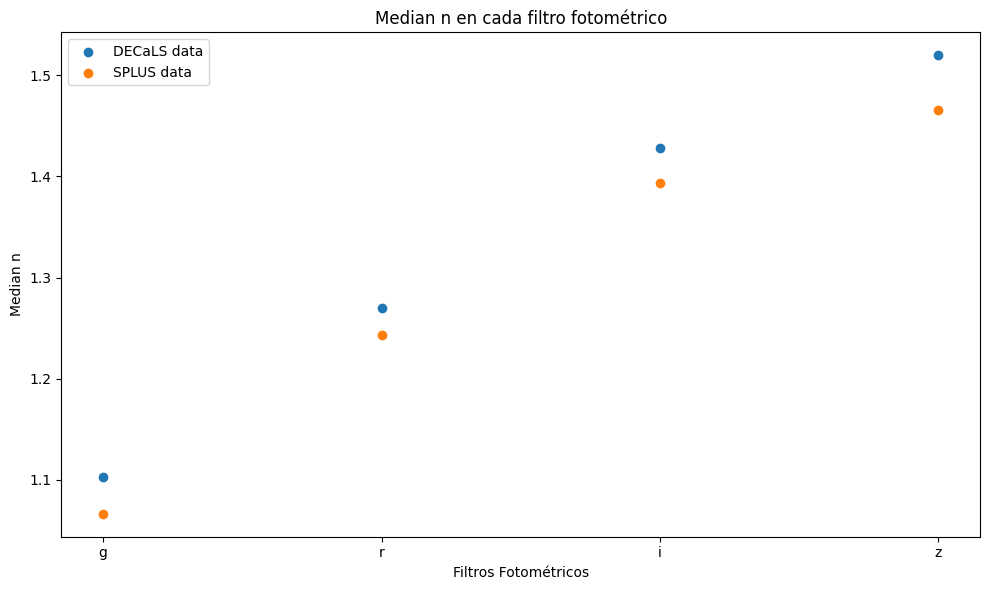

In [21]:
# Crear el gráfico de puntos
plt.figure(figsize=(10, 6))

plt.scatter(filtros, medianas_valores_sersic, label='DECaLS data')
plt.scatter(filtros, medianas_valores_sersic_splus, label='SPLUS data')

# Personalizar el gráfico
plt.xticks(range(len(filtros)), filtros)  # Etiquetas del eje x
plt.xlabel('Filtros Fotométricos')
plt.ylabel('Median n')
plt.title('Median n en cada filtro fotométrico')
#plt.legend()

plt.legend()

plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [22]:
valores_re = np.array([decals['RE_' + filtro] for filtro in filtros])
valores_re_splus = np.array([splus['RE_'+filtro] for filtro in filtros])
# Función para calcular la mediana sin NaN y ceros
def calcular_mediana_sin_nan_ni_ceros(valores):
    # Filtrar NaN y ceros
    valores_filtrados = valores[(~np.isnan(valores)) & (valores != 0)]
    if len(valores_filtrados) > 0:
        return np.median(valores_filtrados)
    else:
        return np.nan

# Calcular medianas para cada filtro en 'valores_sersic'
medianas_valores_re = np.array([calcular_mediana_sin_nan_ni_ceros(valores_re[i]) for i in range(len(filtros))])*0.262

# Calcular medianas para cada filtro en 'valores_sersic_splus'
medianas_valores_re_splus = np.array([calcular_mediana_sin_nan_ni_ceros(valores_re_splus[i]) for i in range(len(filtros))])*0.55

# Imprimir resultados
print("Medianas para valores_re:")
print(medianas_valores_re)

print("\nMedianas para valores_re_splus:")
print(medianas_valores_re_splus)

Medianas para valores_re:
[3.4290691 3.388577  3.329103  3.3225268]

Medianas para valores_re_splus:
[3.085445  2.782505  2.6526775 2.56795  ]


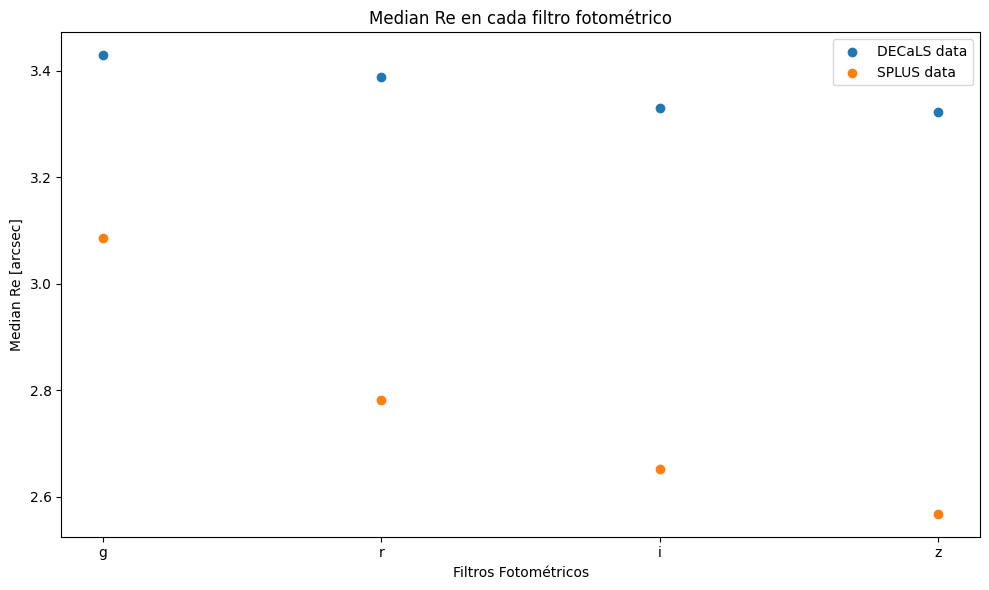

In [23]:
# Crear el gráfico de puntos
plt.figure(figsize=(10, 6))

plt.scatter(filtros, medianas_valores_re, label='DECaLS data')
plt.scatter(filtros, medianas_valores_re_splus, label='SPLUS data')

# Personalizar el gráfico
plt.xticks(range(len(filtros)), filtros)  # Etiquetas del eje x
plt.xlabel('Filtros Fotométricos')
plt.ylabel('Median Re [arcsec]')
plt.title('Median Re en cada filtro fotométrico')
#plt.legend()

plt.legend()

plt.tight_layout()

# Mostrar el gráfico
plt.show()

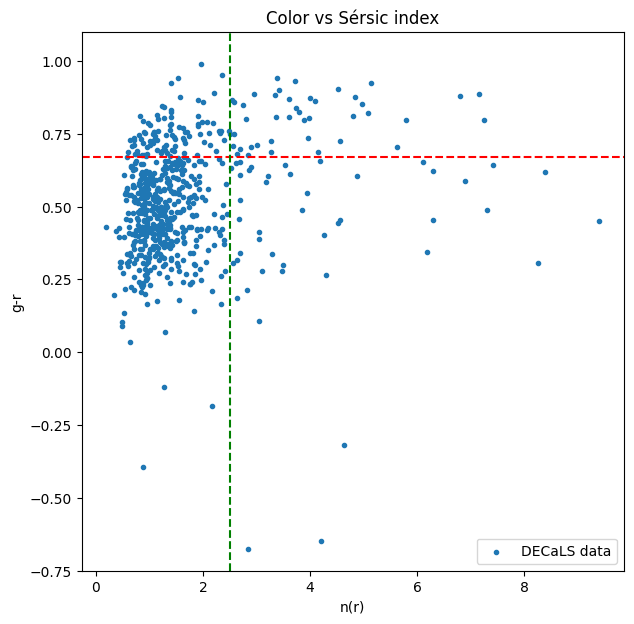

In [25]:
#u_r_o = filtered_splus['MAG_g'] - filtered_splus['MAG_r']
decals_no_zero = decals[decals['n_r']!=0.0]
g_r_decals = decals_no_zero['MAG_g_1'] - decals_no_zero['MAG_r_1']

decals_no_zero_stars = d_stars[d_stars['n_r']!=0.0]
g_r_decals_stars = decals_no_zero_stars['MAG_g_1'] - decals_no_zero_stars['MAG_r_1']
plt.figure(figsize=(7, 7))

plt.scatter(decals_no_zero['n_r'], g_r_decals, marker='.', label='DECaLS data')
#plt.scatter(decals_no_zero_stars['n_r'], g_r_decals_stars, marker='.', label='Stars')

plt.ylim(-0.75, 1.1)
#plt.xlim(0, )
plt.title('Color vs Sérsic index')
plt.xlabel('n(r)')
plt.ylabel('g-r')
# Añadir una línea horizontal en y=50
plt.legend(loc='lower right')
plt.axhline(y=0.67, color='r', linestyle='--')

# Añadir una línea vertical en x=5
plt.axvline(x=2.5, color='g', linestyle='--')
plt.show()

In [7]:
grouped_decals = decals.group_by('Group_1')

valid_groups=[]

for group in grouped_decals.groups:
    if any (group['zmemb'] != 0):
        valid_groups.append(group['Group_1'][0])

filtered_table = decals[np.isin(decals['Group_1'], valid_groups)]

# Crear una función para reemplazar los valores de 'zmemb' que son 0
def replace_zeros(group):
    non_zero_values = group['zmemb'][group['zmemb'] != 0]
    if len(non_zero_values) > 0:
        replacement_value = non_zero_values[0]
        group['zmemb'] = np.where(group['zmemb'] == 0, replacement_value, group['zmemb'])
    return group

# Aplicar la función a cada grupo y unir los resultados
result_groups = []
for group in filtered_table.group_by('Group_1').groups:
    result_groups.append(replace_zeros(group))

table_redshift = vstack(result_groups)

final_table = table_redshift[table_redshift['n_i']!=0.0]
final_table_z = table_redshift[table_redshift['n_z'] != 0.0]


print(len(final_table), len(final_table_z))

389 493


### Calculamos la masa estelar de las galaxias (Taylor et al. 2011)

##### $log(M_{*}/M_{\odot}) = 1.15 + 0.7 \times (g-i)_{0} - 0.4 \times M_{i}$

### La magnitud absoluta utilizando el módulo de distancia 

#### $m - M = 5log(\frac{D}{1pc}) - 5 $

### La distancia utilizando Ley de Hubble-Lemaitre

#### $D = \frac{cz}{H_{0}}$

Con c = 300000 km/s y $H_0$ = 67.4 km/s/Mpc

In [12]:
H_0 = 67.4 #km/s/Mpc
c = 300000
final_table['Distance (Mpc)'] = (final_table['zmemb']*c)/H_0

final_table['M_FUV'] = final_table['FUV'] - 5*np.log10(final_table['Distance (Mpc)']*1000000) + 5
final_table['M_NUV'] = final_table['NUV'] - 5*np.log10(final_table['Distance (Mpc)']*1000000) + 5
final_table['M_i'] = final_table['mag_i_2'] - 5*np.log10(final_table['Distance (Mpc)']*1000000) + 5
final_table['M_z'] = final_table['mag_z_2'] - 5*np.log10(final_table['Distance (Mpc)']*1000000) + 5

final_table['log(M_*)'] = (1.15 + 0.7*(final_table['mag_g_2'] - final_table['mag_i_2']) - 0.4*final_table['M_i'])*u.M_sun
final_table['log(M_*)_z'] = (1.15 + 0.7*(final_table['mag_g_2'] - final_table['mag_z_2']) - 0.4*final_table['M_z'])*u.M_sun

In [9]:
final_table_z['Distance (Mpc)'] = (final_table_z['zmemb']*c)/H_0

final_table_z['M_z'] = final_table_z['mag_z_2'] - 5*np.log10(final_table_z['Distance (Mpc)']*1000000) + 5
final_table_z['log(M_*)'] = (1.15 + 0.7*(final_table_z['mag_g_2'] - final_table_z['mag_z_2']) - 0.4*final_table_z['M_z'])*u.M_sun

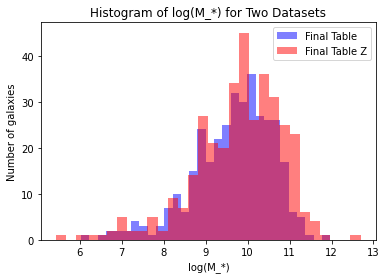

In [13]:
# Suponiendo que 'final_table' y 'final_table_z' son tus tablas
data1 = final_table['log(M_*)']
data2 = final_table['log(M_*)_z']

# Crear el histograma con transparencia
plt.hist(data1, bins=30, alpha=0.5, label='Final Table', color='blue')
plt.hist(data2, bins=30, alpha=0.5, label='Final Table Z', color='red')

# Agregar etiquetas y título
plt.xlabel('log(M_*)')
plt.ylabel('Number of galaxies')
plt.title('Histogram of log(M_*) for Two Datasets')

# Agregar una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

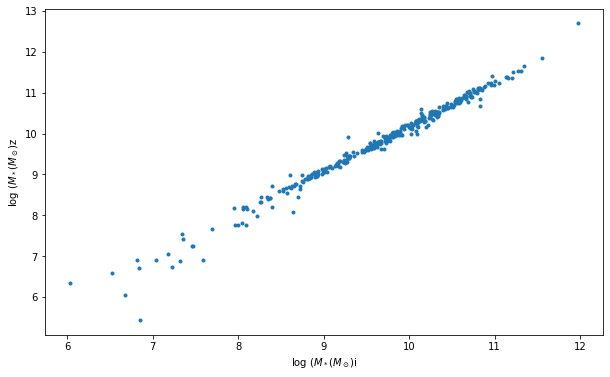

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(data1, data2, marker = '.')
plt.xlabel(f'log ($M_*(M_\odot$)i')
plt.ylabel(f'log ($M_*(M_\odot$)z')

plt.show()

In [22]:
gwsl = Table.read('xmatch_gswl.csv', format='ascii')
gwsl

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,_RAJ2000_1,_DEJ2000_1,Group,Gal,RAJ2000_1,DEJ2000_1,zmemb_1,gmemb_1,FUV_1,NUV_1,Simbad_1,Separation_1,Group_1,Gal_1,ID,ra_1,dec_1,type_1,CHI2NU,XC_g,e_XC_g,YC_g,e_YC_g,RE_g,e_RE_g,MAG_g_1,e_MAG_g,n_g,e_n_g,AR_g,e_AR_g,PA_g,e_PA_g,XC_r,e_XC_r,YC_r,e_YC_r,RE_r,e_RE_r,MAG_r_1,e_MAG_r,n_r,e_n_r,AR_r,e_AR_r,PA_r,e_PA_r,XC_i,e_XC_i,YC_i,e_YC_i,RE_i,e_RE_i,MAG_i_1,e_MAG_i,n_i,e_n_i,AR_i,e_AR_i,PA_i,e_PA_i,XC_z,e_XC_z,YC_z,e_YC_z,RE_z,e_RE_z,MAG_z_1,e_MAG_z,n_z,e_n_z,AR_z,e_AR_z,PA_z,e_PA_z,brickid,brickname,objid,type_2,ra_2,dec_2,ebv,flux_g,flux_r,flux_i,flux_z,psfsize_g,psfsize_r,psfsize_i,psfsize_z,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,mag_g_2,mag_r_2,mag_i_2,mag_z_2,mag_w1,mag_w2,mag_w3,mag_w4,g_r,r_i,r_z,i_z,_RAJ2000_2,_DEJ2000_2,Group_2,Gal_2,RAJ2000_2,DEJ2000_2,zmemb_2,gmemb_2,FUV_2,NUV_2,Simbad_2,Separation_2,Separation_2a,Separation
int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,int64,int64,str11,str11,float64,int64,float64,float64,str6,float64,int64,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str8,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str8,str8,str8,float64,float64,int64,str8,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str11,str11,float64,int64,float64,float64,str6,float64,float64,float64
1237648720151511345,6381963739594231963,278,51900,87,167.51669,-1.004932,0.1098,1.05,10.126,0.078,0.669,0.035,1.305,0.146,0.171,0.042,0.102,0.03,0,1,3,2,1,167.5169583,-1.00475,97,2,11 10 04.07,-01 00 17.1,0.109852,--,20.0003,19.0302,Simbad,1.1670151244919116,97,2,391,167.5168502117463,-1.004677110111772,EXP,0.574185303565978,784.4078,0.0028,774.8491,0.0019,4.9786,0.0106,17.975,0.0018,1.4321,0.008,0.5077,0.0008,55.4309,0.0789,784.4078,0.0028,774.8491,0.0019,4.8736,0.0071,17.6582,0.0012,1.4060,0.0049,0.5077,0.0008,55.4309,0.0789,784.4078,0.0028,774.8491,0.0019,4.7734,0.0079,17.3338,0.0014,1.381,0.005,0.5077,0.0008,55.4309,0.0789,784.4078,0.0028,774.8491,0.0019,4.665,0.0125,17.3093,0.0022,1.3540,0.0085,0.5077,0.0008,55.4309,0.0789,325278,1676m010,391,EXP,167.5168502117463,-1.004677110111772,0.037206035,4.384323,5.5599747,5.2908816,4.533846,1.1402005,1.31659,1.0861177,1.1228145,1.0,0.0,3.681527,280.40057,-0.47609255,5756.203,0.4195744,6383.8433,20.895243,20.637318,20.69118,20.858833,21.112875,--,16.409658,12.971799,0.25792503,-0.053861618,-0.22151566,-0.16765404,167.5169583,-1.00475,97,2,11 10 04.07,-01 00 17.1,0.109852,--,20.0003,19.0302,Simbad,0.4692778376917035,0.0,0.0
1237648720152035469,6381963749257908697,279,51984,201,168.64726,-0.867553,0.0692,0.56,9.833,0.075,0.408,0.06,1.432,0.195,0.322,0.089,0.218,0.069,0,1,3,2,1,168.6475417,-0.8678056,273,5,11 14 35.41,-00 52 04.1,0.069293,--,19.6415,18.8591,Simbad,1.3620349273567411,273,5,3416,168.6477687319171,-0.8678292086364374,SER,0.799594529715566,502.4512,0.0051,477.8328,0.0033,10.188,0.0198,17.4823,0.0016,1.3054,0.0043,0.5525,0.0006,73.5156,0.0745,502.4512,0.0051,477.8328,0.0033,10.0116,0.0134,17.0709,0.0012,1.4697,0.0029,0.5525,0.0006,73.5156,0.0745,502.4512,0.0051,477.8328,0.0033,9.8433,0.0201,16.918,0.0018,1.6264,0.0044,0.5525,0.0006,73.5156,0.0745,502.4512,0.0051,477.8328,0.0033,9.6612,0.0334,16.8136,0